In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Extract Spark/Hadoop and install PyPython dependencies**

In [2]:
#######################################
###!@0 START INIT ENVIRONMENT
!ls /content/drive/Shareddrives/DA231o-2024-shared/assignments/SparkData/spark-3.5.2-bin-hadoop3.tgz
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!tar xf /content/drive/Shareddrives/DA231o-2024-shared/assignments/SparkData/spark-3.5.2-bin-hadoop3.tgz
!pip install -q findspark
!pip install -q pyspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.2-bin-hadoop3"
###!@0 END INIT ENVIRONMENT

/content/drive/Shareddrives/DA231o-2024-shared/assignments/SparkData/spark-3.5.2-bin-hadoop3.tgz


**Create spark session**

In [3]:
#######################################
###!@1 START OF PYSPARK INIT
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
input_type = 'sample'
spark = SparkSession.builder\
         .master("local")\
         .appName("Colab")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()
# Spark is ready to go within Colab!
###!@1 END OF PYSPARK INIT

In [4]:
import requests
cdc_url = 'https://raw.githubusercontent.com/kapsoniiisc/diabetes-dsp-project/refs/heads/main/Dataset/diabetes_binary_health_indicators_BRFSS2015.csv'

# Download the files locally
with open('cdc_data.csv', 'wb') as f:
    f.write(requests.get(cdc_url).content)

cdc_data = spark.read.csv('cdc_data.csv', header=True, inferSchema=True)

In [5]:
################Iomport lib ##############
from pyspark.sql.functions import col, sum, when
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import warnings
from pyspark.sql import functions as F
from pyspark.sql.functions import corr
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np

**Model Development: CDC Data: Random Forest**

Selected Features

In [6]:
selected_features = ['HighBP', 'HighChol', 'BMI', 'PhysActivity', 'GenHlth', 'MentHlth', 'PhysHlth',
                     'DiffWalk', 'Age', 'Education', 'Income', 'Stroke', 'HeartDiseaseorAttack']

**Random Forest Model Feature Importance**

In [7]:
selected_features = ['HighBP', 'HighChol', 'BMI', 'PhysActivity', 'GenHlth', 'MentHlth', 'PhysHlth',
                     'DiffWalk', 'Age', 'Education', 'Income', 'Stroke', 'HeartDiseaseorAttack']
label_column = 'Diabetes_binary'

assembler = VectorAssembler(inputCols=selected_features, outputCol="features")

rf = RandomForestClassifier(featuresCol="features", labelCol=label_column, numTrees=100)

pipeline = Pipeline(stages=[assembler, rf])

train_data, test_data = cdc_data.randomSplit([0.8, 0.2], seed=42)

rf_model = pipeline.fit(train_data)

rf_stage = rf_model.stages[-1]
feature_importances = rf_stage.featureImportances

importances = [(feature, importance) for feature, importance in zip(selected_features, feature_importances)]
sorted_importances = sorted(importances, key=lambda x: x[1], reverse=True)

print("Feature Importances:")
for feature, importance in sorted_importances:
    print(f"{feature}: {importance:.4f}")

Feature Importances:
HighBP: 0.3073
GenHlth: 0.2308
DiffWalk: 0.1717
BMI: 0.1255
HighChol: 0.0869
HeartDiseaseorAttack: 0.0392
PhysHlth: 0.0213
Age: 0.0118
Income: 0.0044
Stroke: 0.0007
Education: 0.0002
PhysActivity: 0.0002
MentHlth: 0.0001


feature importance indicates the relative contribution of each feature in predicting the target variable.

It is calculated based on how much each feature improves the model's split criterion (e.g., Gini impurity or information gain) across all trees in the forest


Higher Importance (e.g., >0.1): Features with higher importance contribute more significantly to the model's predictions.


Moderate Importance (e.g., 0.05–0.1):These features are somewhat relevant but not as influential.For example, if HighChol has an importance value of 0.07, it suggests that while cholesterol impacts the predictions, it's not the sole factor


Lower Importance (e.g., <0.05):Features with low importance values are used less frequently in decision tree splits or add minimal predictive value. Influential Factors: High blood pressure, BMI , poor general health, and Diffwalk are significant predictors of diabetes risk, with high blood pressure having the strongest association.

**PLot the Confusion Matrix**

<Figure size 800x600 with 0 Axes>

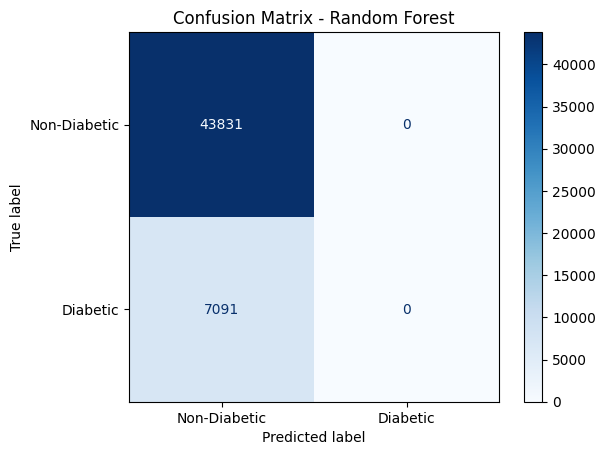

In [8]:
predictions = rf_model.transform(test_data)

y_true = predictions.select(label_column).rdd.flatMap(lambda x: x).collect()
y_pred = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Non-Diabetic", "Diabetic"])
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix - Random Forest")
plt.show()

**Calculate Evaluation Metrics**

In [9]:
train_predictions = rf_model.transform(train_data)
test_predictions = rf_model.transform(test_data)

accuracy_evaluator = MulticlassClassificationEvaluator(labelCol=label_column, predictionCol="prediction", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol=label_column, predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol=label_column, predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol=label_column, predictionCol="prediction", metricName="f1")
roc_auc_evaluator = BinaryClassificationEvaluator(labelCol=label_column, rawPredictionCol="rawPrediction", metricName="areaUnderROC")

train_accuracy = accuracy_evaluator.evaluate(train_predictions)
train_precision = precision_evaluator.evaluate(train_predictions)
train_recall = recall_evaluator.evaluate(train_predictions)
train_f1_score = f1_evaluator.evaluate(train_predictions)
train_roc_auc = roc_auc_evaluator.evaluate(train_predictions)

test_accuracy = accuracy_evaluator.evaluate(test_predictions)
test_precision = precision_evaluator.evaluate(test_predictions)
test_recall = recall_evaluator.evaluate(test_predictions)
test_f1_score = f1_evaluator.evaluate(test_predictions)
test_roc_auc = roc_auc_evaluator.evaluate(test_predictions)

print("### Training Data Metrics ###")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-Score: {train_f1_score:.4f}")
print(f"ROC AUC: {train_roc_auc:.4f}")

print("\n### Test Data Metrics ###")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1_score:.4f}")
print(f"ROC AUC: {test_roc_auc:.4f}")

### Training Data Metrics ###
Accuracy: 0.8606
Precision: 0.7407
Recall: 0.8606
F1-Score: 0.7962
ROC AUC: 0.8014

### Test Data Metrics ###
Accuracy: 0.8607
Precision: 0.7409
Recall: 0.8607
F1-Score: 0.7963
ROC AUC: 0.7978


**Calculate the MSE and RMSE**

In [10]:
mse_evaluator = RegressionEvaluator(labelCol=label_column, predictionCol="prediction", metricName="mse")
rmse_evaluator = RegressionEvaluator(labelCol=label_column, predictionCol="prediction", metricName="rmse")

train_mse = mse_evaluator.evaluate(train_predictions)
train_rmse = rmse_evaluator.evaluate(train_predictions)

test_mse = mse_evaluator.evaluate(test_predictions)
test_rmse = rmse_evaluator.evaluate(test_predictions)

print("### Training Data Metrics ###")
print(f"MSE: {train_mse:.4f}")
print(f"RMSE: {train_rmse:.4f}")

print("\n### Test Data Metrics ###")
print(f"MSE: {test_mse:.4f}")
print(f"RMSE: {test_rmse:.4f}")

### Training Data Metrics ###
MSE: 0.1394
RMSE: 0.3733

### Test Data Metrics ###
MSE: 0.1393
RMSE: 0.3732


**Random Foreset Classifier with cross validation**

In [11]:
training_accuracies = []
testing_accuracies = []

training_f1 = []
testing_f1 = []

training_precision = []
testing_precision = []

training_recall = []
testing_recall = []

training_rocauc_score = []
testing_rocauc_score = []

selected_features = ['HighBP', 'HighChol', 'BMI', 'PhysActivity', 'GenHlth', 'MentHlth', 'PhysHlth',
                     'DiffWalk', 'Age', 'Education', 'Income', 'Stroke', 'HeartDiseaseorAttack']
label_column = 'Diabetes_binary'

assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
rf = RandomForestClassifier(featuresCol="features", labelCol=label_column, numTrees=100)

pipeline = Pipeline(stages=[assembler, rf])
train_data, test_data = cdc_data.randomSplit([0.8, 0.2], seed=42)

paramGrid = ParamGridBuilder().build()
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=accuracy_evaluator,
                          numFolds=5)
cv_model = crossval.fit(train_data)


accuracy_evaluator = MulticlassClassificationEvaluator(labelCol=label_column, predictionCol="prediction", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol=label_column, predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol=label_column, predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol=label_column, predictionCol="prediction", metricName="f1")
roc_evaluator = BinaryClassificationEvaluator(labelCol=label_column, rawPredictionCol="rawPrediction", metricName="areaUnderROC")

fold_metrics = cv_model.avgMetrics

for fold_idx in range(len(fold_metrics)):

  train_predictions = cv_model.transform(train_data)
  training_accuracies.append(accuracy_evaluator.evaluate(train_predictions))
  training_precision.append(precision_evaluator.evaluate(train_predictions))
  training_recall.append(recall_evaluator.evaluate(train_predictions))
  training_f1.append(f1_evaluator.evaluate(train_predictions))
  training_rocauc_score.append(roc_evaluator.evaluate(train_predictions))

  test_predictions = cv_model.transform(test_data)
  testing_accuracies.append(accuracy_evaluator.evaluate(test_predictions))
  testing_precision.append(precision_evaluator.evaluate(test_predictions))
  testing_recall.append(recall_evaluator.evaluate(test_predictions))
  testing_f1.append(f1_evaluator.evaluate(test_predictions))
  testing_rocauc_score.append(roc_evaluator.evaluate(test_predictions))

mean_train_accuracy_lr_iter1 = np.mean(training_accuracies)
std_train_accuracy_lr_iter1 = np.std(training_accuracies)
mean_test_accuracy_lr_iter1 = np.mean(testing_accuracies)
std_test_accuracy_lr_iter1 = np.std(testing_accuracies)

print("\n")
print("="*50)
print(f"Training Accuracy: {mean_train_accuracy_lr_iter1:.2f} ± {std_train_accuracy_lr_iter1:.2f}")
print(f"Test Accuracy: {mean_test_accuracy_lr_iter1:.2f} ± {std_test_accuracy_lr_iter1:.2f}")
print("="*50)


mean_train_f1_lr_iter1 = np.mean(training_f1)
std_train_f1_lr_iter1 = np.std(training_f1)
mean_test_f1_lr_iter1 = np.mean(testing_f1)
std_test_f1_lr_iter1 = np.std(testing_f1)

print("\n")
print("="*50)
print(f"Training F1: {mean_train_f1_lr_iter1:.2f} ± {std_train_f1_lr_iter1:.2f}")
print(f"Test F1: {mean_test_f1_lr_iter1:.2f} ± {std_test_f1_lr_iter1:.2f}")
print("="*50)


mean_train_precision_lr_iter1 = np.mean(training_precision)
std_train_precision_lr_iter1 = np.std(training_precision)
mean_test_precision_lr_iter1 = np.mean(testing_precision)
std_test_precision_lr_iter1 = np.std(testing_precision)

print("\n")
print("="*50)
print(f"Training Precision: {mean_train_precision_lr_iter1:.2f} ± {std_train_precision_lr_iter1:.2f}")
print(f"Test Precision: {mean_test_precision_lr_iter1:.2f} ± {std_test_precision_lr_iter1:.2f}")
print("="*50)


mean_train_recall_lr_iter1 = np.mean(training_recall)
std_train_recall_lr_iter1 = np.std(training_recall)
mean_test_recall_lr_iter1 = np.mean(testing_recall)
std_test_recall_lr_iter1 = np.std(testing_recall)

print("\n")
print("="*50)
print(f"Training Recall: {mean_train_recall_lr_iter1:.2f} ± {std_train_recall_lr_iter1:.2f}")
print(f"Test Recall: {mean_test_recall_lr_iter1:.2f} ± {std_test_recall_lr_iter1:.2f}")
print("="*50)


mean_train_rocauc_score_lr_iter1 = np.mean(training_rocauc_score)
std_train_rocauc_score_lr_iter1 = np.std(training_rocauc_score)
mean_test_rocauc_score_lr_iter1 = np.mean(testing_rocauc_score)
std_test_rocauc_score_lr_iter1 = np.std(testing_rocauc_score)

print("\n")
print("="*50)
print(f"Training RO-AUC: {mean_train_rocauc_score_lr_iter1:.2f} ± {std_train_rocauc_score_lr_iter1:.2f}")
print(f"Test RO-AUC: {mean_test_rocauc_score_lr_iter1:.2f} ± {std_test_rocauc_score_lr_iter1:.2f}")
print("="*50)



Training Accuracy: 0.86 ± 0.00
Test Accuracy: 0.86 ± 0.00


Training F1: 0.80 ± 0.00
Test F1: 0.80 ± 0.00


Training Precision: 0.74 ± 0.00
Test Precision: 0.74 ± 0.00


Training Recall: 0.86 ± 0.00
Test Recall: 0.86 ± 0.00


Training RO-AUC: 0.80 ± 0.00
Test RO-AUC: 0.80 ± 0.00


**Random Forest Model with Cross-Validation and Hyperparameter Tuning**

In [12]:
training_accuracies = []
testing_accuracies = []

training_f1 = []
testing_f1 = []

training_precision = []
testing_precision = []

training_recall = []
testing_recall = []

training_rocauc_score = []
testing_rocauc_score = []

selected_features = ['HighBP', 'HighChol', 'BMI', 'PhysActivity', 'GenHlth', 'MentHlth', 'PhysHlth',
                     'DiffWalk', 'Age', 'Education', 'Income', 'Stroke', 'HeartDiseaseorAttack']
label_column = 'Diabetes_binary'

assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
rf = RandomForestClassifier(featuresCol="features", labelCol=label_column, numTrees=100)

pipeline = Pipeline(stages=[assembler, rf])
train_data, test_data = cdc_data.randomSplit([0.8, 0.2], seed=42)

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=accuracy_evaluator,
                          numFolds=5)
cv_model = crossval.fit(train_data)

best_model = cv_model.bestModel
best_rf_stage = best_model.stages[-1]

accuracy_evaluator = MulticlassClassificationEvaluator(labelCol=label_column, predictionCol="prediction", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol=label_column, predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol=label_column, predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol=label_column, predictionCol="prediction", metricName="f1")
roc_evaluator = BinaryClassificationEvaluator(labelCol=label_column, rawPredictionCol="rawPrediction", metricName="areaUnderROC")

fold_metrics = cv_model.avgMetrics

for fold_idx in range(len(fold_metrics)):

  train_predictions = cv_model.transform(train_data)
  training_accuracies.append(accuracy_evaluator.evaluate(train_predictions))
  training_precision.append(precision_evaluator.evaluate(train_predictions))
  training_recall.append(recall_evaluator.evaluate(train_predictions))
  training_f1.append(f1_evaluator.evaluate(train_predictions))
  training_rocauc_score.append(roc_evaluator.evaluate(train_predictions))

  test_predictions = cv_model.transform(test_data)
  testing_accuracies.append(accuracy_evaluator.evaluate(test_predictions))
  testing_precision.append(precision_evaluator.evaluate(test_predictions))
  testing_recall.append(recall_evaluator.evaluate(test_predictions))
  testing_f1.append(f1_evaluator.evaluate(test_predictions))
  testing_rocauc_score.append(roc_evaluator.evaluate(test_predictions))

# Calculate mean and standard deviation of accuracies
mean_train_accuracy_lr_iter1 = np.mean(training_accuracies)
std_train_accuracy_lr_iter1 = np.std(training_accuracies)
mean_test_accuracy_lr_iter1 = np.mean(testing_accuracies)
std_test_accuracy_lr_iter1 = np.std(testing_accuracies)

# Print results
print("\n")
print("="*50)
print(f"Training Accuracy: {mean_train_accuracy_lr_iter1:.2f} ± {std_train_accuracy_lr_iter1:.2f}")
print(f"Test Accuracy: {mean_test_accuracy_lr_iter1:.2f} ± {std_test_accuracy_lr_iter1:.2f}")
print("="*50)

# Calculate mean and standard deviation of f1 scores

mean_train_f1_lr_iter1 = np.mean(training_f1)
std_train_f1_lr_iter1 = np.std(training_f1)
mean_test_f1_lr_iter1 = np.mean(testing_f1)
std_test_f1_lr_iter1 = np.std(testing_f1)

# Print results
print("\n")
print("="*50)
print(f"Training F1: {mean_train_f1_lr_iter1:.2f} ± {std_train_f1_lr_iter1:.2f}")
print(f"Test F1: {mean_test_f1_lr_iter1:.2f} ± {std_test_f1_lr_iter1:.2f}")
print("="*50)

# Calculate mean and standard deviation of Precision scores

mean_train_precision_lr_iter1 = np.mean(training_precision)
std_train_precision_lr_iter1 = np.std(training_precision)
mean_test_precision_lr_iter1 = np.mean(testing_precision)
std_test_precision_lr_iter1 = np.std(testing_precision)

# Print results
print("\n")
print("="*50)
print(f"Training Precision: {mean_train_precision_lr_iter1:.2f} ± {std_train_precision_lr_iter1:.2f}")
print(f"Test Precision: {mean_test_precision_lr_iter1:.2f} ± {std_test_precision_lr_iter1:.2f}")
print("="*50)

# Calculate mean and standard deviation of Recall scores

mean_train_recall_lr_iter1 = np.mean(training_recall)
std_train_recall_lr_iter1 = np.std(training_recall)
mean_test_recall_lr_iter1 = np.mean(testing_recall)
std_test_recall_lr_iter1 = np.std(testing_recall)

# Print results
print("\n")
print("="*50)
print(f"Training Recall: {mean_train_recall_lr_iter1:.2f} ± {std_train_recall_lr_iter1:.2f}")
print(f"Test Recall: {mean_test_recall_lr_iter1:.2f} ± {std_test_recall_lr_iter1:.2f}")
print("="*50)

# Calculate mean and standard deviation of RO-AUC scores

mean_train_rocauc_score_lr_iter1 = np.mean(training_rocauc_score)
std_train_rocauc_score_lr_iter1 = np.std(training_rocauc_score)
mean_test_rocauc_score_lr_iter1 = np.mean(testing_rocauc_score)
std_test_rocauc_score_lr_iter1 = np.std(testing_rocauc_score)

# Print results
print("\n")
print("="*50)
print(f"Training RO-AUC: {mean_train_rocauc_score_lr_iter1:.2f} ± {std_train_rocauc_score_lr_iter1:.2f}")
print(f"Test RO-AUC: {mean_test_rocauc_score_lr_iter1:.2f} ± {std_test_rocauc_score_lr_iter1:.2f}")
print("="*50)


importances = [(feature, importance) for feature, importance in zip(selected_features, best_rf_stage.featureImportances)]
sorted_importances = sorted(importances, key=lambda x: x[1], reverse=True)
print("\nFeature Importances:")
for feature, importance in sorted_importances:
    print(f"{feature}: {importance:.4f}")



Training Accuracy: 0.87 ± 0.00
Test Accuracy: 0.87 ± 0.00


Training F1: 0.83 ± 0.00
Test F1: 0.82 ± 0.00


Training Precision: 0.84 ± 0.00
Test Precision: 0.83 ± 0.00


Training Recall: 0.87 ± 0.00
Test Recall: 0.87 ± 0.00


Training RO-AUC: 0.83 ± 0.00
Test RO-AUC: 0.82 ± 0.00

Feature Importances:
HighBP: 0.2427
GenHlth: 0.2312
BMI: 0.1564
DiffWalk: 0.0931
HighChol: 0.0918
Age: 0.0671
HeartDiseaseorAttack: 0.0287
PhysHlth: 0.0277
Income: 0.0228
Education: 0.0141
MentHlth: 0.0128
Stroke: 0.0061
PhysActivity: 0.0054
